In [1]:
# import modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # for plotting in seaborn
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
import math # for mathematical operations

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


In [3]:
########################
### SET PATH TO DATA ###
########################

# set the folder name
# folder name = a single plant shoot

folder = "Pcae2"

In [4]:
##################################################
### LOAD IN AND FORMAT DATA FOR LEAF LANDMARKS ###
##################################################

# read in landmarks file
landmarks = pd.read_csv(folder + "/" + folder + "_landmarks.csv")

# set column names
landmarks.columns = ["row", "file", "x", "y"]

# specify whether landmark is leaf base or tip
landmarks["type"] = np.where(landmarks.index%2==0, "base", "tip")

# get the total number of nodes
node_num = int(len(landmarks)/2)

# double each node number
nodes = [i for i in range(1, node_num + 1) for _ in range(2)]

# add node identity to landmark df
landmarks["node"] = nodes

# load in pixels per cm scale
px_cm = float(np.loadtxt(folder + "/" + folder + "_cm.txt"))

In [5]:
# set resolution for points on each side of leaf
res = 100

# set high res number of points to interpolate
high_res_pts = 1000

# an array to store pseudo-landmarks
cm_arr = np.zeros((node_num, (res*2)-1, 2))

for i in range(node_num):
    
    # convert index to node number
    lf = i + 1 

    #################################
    ### READ IN LEAF CONTOUR DATA ###
    #################################

    # read in leaf contour file
    lf_contour = np.loadtxt(folder + "/" + folder + "_" + str(lf) + ".txt")

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(lf_contour[:,0], 
                                           lf_contour[:,1],
                                           high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # mask landmark df to find base and tip points
    lf_landmarks = landmarks[landmarks["node"]==lf]
    lf_base = lf_landmarks[lf_landmarks["type"]=="base"]
    lf_tip = lf_landmarks[lf_landmarks["type"]=="tip"]

    # get the base and tip landmark point values
    base_pt = np.array((lf_base["x"], lf_base["y"]))
    tip_pt = np.array((lf_tip["x"], lf_tip["y"]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))

    # scale leaf into cm
    cm_lf = rot_pts/px_cm

    # translate base to the origin
    
    cm_lf[:,0] = cm_lf[:,0] - cm_lf[0,0]
    cm_lf[:,1] = cm_lf[:,1] - cm_lf[0,1]
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[i,:,:] = cm_lf


In [6]:
############################
### MODEL REAL LEAF AREA ###
############################

# to store actual leaf areas of leaves
leaf_areas = []

# number of intervals to be modeled (should match below)
intervals = 100

# calculate actual area for each leaf
for i in range(len(cm_arr)):
    leaf_areas.append(poly_area(cm_arr[i,:,0], cm_arr[i,:,1]))
    
# interpolate along areas for modeled areas
intervals, real_areas = interpolation([i for i in range(node_num)],
                                     leaf_areas,
                                     intervals)

In [7]:
###########################
### PROCRUSTES ANALYSIS ###
###########################

landmark_num = res*2-1
dim_num = 2

leaf_mean = gpa_mean(cm_arr, landmark_num, dim_num)

# an array to store procrustes aligned shapes
proc_arr = np.zeros((np.shape(cm_arr)[0],
                     np.shape(cm_arr)[1],
                     np.shape(cm_arr)[2]
                    ))
# for each leaf
for i in range(np.shape(cm_arr)[0]):

    # calculate superimposed shape to gpa_mean
    s1, s2, distance = procrustes(leaf_mean, cm_arr[i,:,:]) 
    
    # append procrustes shape to array
    proc_arr[i,:,:] = s2


In [8]:
################################
### MODEL LEAF SHAPE BY NODE ###
################################

intervals = 100
poly_order = 10

# an array to hold the  modeled data
model_arr = np.zeros((intervals, 2*res-1, 2))

for i in range(2*res-1): # for i landmarks 

    for j in range(2): # for j coordinates in x and y, 0 and 1

        # fit function across nodes for current i, j landmark coord val
        N = np.polyfit(np.array([i for i in range(1, node_num + 1)]),
                       proc_arr[:, i, j], 
                       poly_order )
        
        func = np.poly1d(N)

        # model vals over nodes
        model_vals = func(np.linspace(1,node_num,intervals))

        # place modeled values into array
        model_arr[0:100, i, j] = model_vals

In [9]:
#####################################
### ADJUST MODELED LEAVES BY AREA ###
#####################################

# an array to hold the modeled areas
model_areas = np.zeros((intervals))

# calculate the area of the modeled leaves
for i in range(len(model_arr)):
    model_areas[i] = poly_area(model_arr[i,:,0], model_arr[i,:,1])
    
# an array to hold modeled leaves adjusted for area
area_arr = np.zeros((intervals, 2*res-1, 2))

# calculate adjusted leaf outlines by area
for i in range(len(model_arr)):
    area_arr[i,:,0] = model_arr[i,:,0]*np.sqrt(real_areas[i]/model_areas[i])
    area_arr[i,:,1] = model_arr[i,:,1]*np.sqrt(real_areas[i]/model_areas[i])


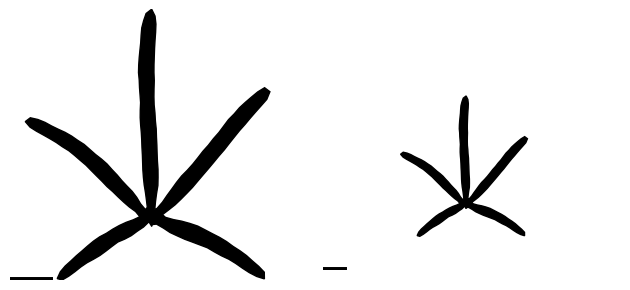

In [10]:
############
### PLOT ###
############

# select leaf
i = 0

# the modeled leaf area
plt.subplot(1,2,1)
plt.fill(model_arr[i, :, 0], model_arr[i, :, 1], c="k") # plot leaf
plt.gca().set_aspect("equal") # set aspect ratio equal
plt.xlim( np.min(model_arr[:,:,0]), np.max(model_arr[:,:,0]) ) # set overall x lims
plt.ylim( np.min(model_arr[:,:,1]), np.max(model_arr[:,:,1]) ) # set overall y lims
plt.axis("off") # turn axis off
# scale bar
plt.plot(
         [np.min(model_arr[:,:,0]), np.min(model_arr[:,:,0]) + np.sqrt(model_areas[i]/real_areas[i])],
         [np.min(model_arr[:,:,1]), np.min(model_arr[:,:,1])],
         c="k", lw=5
                )

# the real leaf area
plt.subplot(1,2,2)
plt.fill(area_arr[i, :, 0], area_arr[i, :, 1], c="k") # plot leaf
plt.gca().set_aspect("equal") # set aspect ratio equal
plt.xlim( np.min(area_arr[:,:,0]), np.max(area_arr[:,:,0]) ) # set overall x lims
plt.ylim( np.min(area_arr[:,:,1]), np.max(area_arr[:,:,1]) ) # set overall y lims
plt.axis("off") # turn axis off
# scale bar
plt.plot(
         [np.min(area_arr[:,:,0]), np.min(area_arr[:,:,0]) + 1],
         [np.min(area_arr[:,:,1]), np.min(area_arr[:,:,1])],
         c="k", lw=5
                )

plt.tight_layout()


In [11]:
#################
### ANIMATION ###
#################

for i in range(len(model_arr)):

    # the real leaf area
    plt.fill(area_arr[i, :, 0], area_arr[i, :, 1], c="k") # plot leaf
    plt.gca().set_aspect("equal") # set aspect ratio equal
    plt.xlim( np.min(area_arr[:,:,0]), np.max(area_arr[:,:,0]) ) # set overall x lims
    plt.ylim( np.min(area_arr[:,:,1]), np.max(area_arr[:,:,1]) ) # set overall y lims
    plt.axis("off") # turn axis off
    # scale bar
    plt.plot(
             [np.min(area_arr[:,:,0]), np.min(area_arr[:,:,0]) + 1],
             [np.min(area_arr[:,:,1]), np.min(area_arr[:,:,1])],
             c="k", lw=5
                    )

    plt.tight_layout()
    plt.savefig("./animation/leaf_" + str(i) + ".jpg")
    plt.close()